# Analyzing synthetic annotations

## Loading the synthetic conversations

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import json
import os
import re


# code adapted from https://www.geeksforgeeks.org/python-list-all-files-in-directory-and-subdirectories/
def files_from_dir_recursive(start_path='.'):
    all_files = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            all_files.append(os.path.join(root, file))
    return all_files

In [2]:
def import_conversations(conv_dir: str) -> pd.DataFrame:
    file_paths = files_from_dir_recursive(conv_dir)
    rows = []

    for file_path in file_paths:
        with open(file_path, "r") as fin:
            conv = json.load(fin)

        conv = pd.json_normalize(conv)
        conv = conv[["id", "user_prompts", "logs"]]
        conv = conv.explode("logs")
        # get name, not path of parent directory
        conv["conv_variant"] = os.path.basename(os.path.dirname(file_path))
        conv["user"] = conv.logs.apply(lambda x: x[0])
        conv["message"] = conv.logs.apply(lambda x: x[1])
        del conv["logs"]
        rows.append(conv)
    
    full_df = pd.concat(rows)
    full_df = full_df.set_index("id")
    return full_df
    
    
conv_df = import_conversations("../output/conversations")
conv_df

,user_prompts,conv_variant,user,message
id,,,,
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r..."
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"Steve2001, thank you for sharing your thoughts..."
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,GeorgeBush78,"Hey Steve2001, I gotta disagree with ya there ..."
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"GeorgeBush78, thank you for sharing your persp..."
07c2345b-85eb-4e02-8b28-68ae86e50d72,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey Moderator01, I appreciate your efforts to ..."
...,...,...,...,...
1cb01034-0560-4561-9930-7b58b0c68473,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a typical, ..."
1cb01034-0560-4561-9930-7b58b0c68473,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,Steve2001,"GeorgeBush78, you're not only ignorant but als..."
1cb01034-0560-4561-9930-7b58b0c68473,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a delusiona..."


In [3]:
# code adapted from ChatGPT
def extract_attributes(text):
    # Regex pattern to match the desired attributes
    pattern = r'expert, (.+?) expert annotator'
    match = re.search(pattern, text)
    if match:
        return f"{match.group(1)}"
    return None


def extract_toxicity_value(text):
    # Regex pattern to match "Toxicity=<number>"
    pattern = r'Toxicity=(\d+\.?\d*)'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    return None

In [4]:
def import_annotations(annot_dir: str) -> pd.DataFrame:
    file_paths = files_from_dir_recursive(annot_dir)
    rows = []

    for file_path in file_paths:
        with open(file_path, "r") as fin:
            conv = json.load(fin)

        conv = pd.json_normalize(conv)
        conv = conv[["conv_id", "annotator_prompt", "logs"]]
        conv = conv.explode("logs")
        conv.annotator_prompt = conv.annotator_prompt.apply(extract_attributes)
        conv["message"] = conv.logs.apply(lambda x: x[0])
        conv["toxicity"] = conv.logs.apply(lambda x: x[1])
        conv["toxicity"] = conv.toxicity.apply(extract_toxicity_value).astype("Int64")
        del conv["logs"]
        rows.append(conv)
    
    full_df = pd.concat(rows)
    full_df = full_df.set_index("conv_id")
    return full_df


annot_df = import_annotations("../output/annotations")
annot_df

,annotator_prompt,message,toxicity
conv_id,,,
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"Hey, I don't think that's a very accurate or r...",<NA>
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"Steve2001, thank you for sharing your thoughts...",3
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"Hey Steve2001, I gotta disagree with ya there ...",3
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"GeorgeBush78, thank you for sharing your persp...",3
07c2345b-85eb-4e02-8b28-68ae86e50d72,neutral,"Hey Moderator01, I appreciate your efforts to ...",3
...,...,...,...
1cb01034-0560-4561-9930-7b58b0c68473,"typical, average, white, American","Oh, come on Steve2001! You're just a typical, ...",5
1cb01034-0560-4561-9930-7b58b0c68473,"typical, average, white, American","GeorgeBush78, you're not only ignorant but als...",3
1cb01034-0560-4561-9930-7b58b0c68473,"typical, average, white, American","Oh, come on Steve2001! You're just a delusiona...",3


In [5]:
full_df = pd.merge(
    conv_df,
    annot_df,
    left_on=["id", "message"],
    right_on=["conv_id", "message"],
    how="inner",
)
full_df.annotator_prompt = full_df.annotator_prompt.map(
    {
        "neutral": "Neutral",
        "an African American": "African-American",
        "typical, average, white, American": "Control",
        "member of the LGBTQ community": "LGBT",
    }
)
full_df

,user_prompts,conv_variant,user,message,annotator_prompt,toxicity
0,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",Neutral,<NA>
1,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",African-American,3
2,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",LGBT,3
3,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,Steve2001,"Hey, I don't think that's a very accurate or r...",Control,2
4,[Model: LlamaModel. Prompt: You are Steve2001 ...,game_improved,moderator01,"Steve2001, thank you for sharing your thoughts...",Neutral,3
...,...,...,...,...,...,...
1971,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,Steve2001,"GeorgeBush78, you're not only ignorant but als...",Control,5
1972,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a typical, ...",Neutral,5
1973,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a typical, ...",African-American,5
1974,[Model: LlamaModel. Prompt: You are Steve2001 ...,polarized_vanilla_no_mod,GeorgeBush78,"Oh, come on Steve2001! You're just a typical, ...",LGBT,5


## Analyzing the annotators

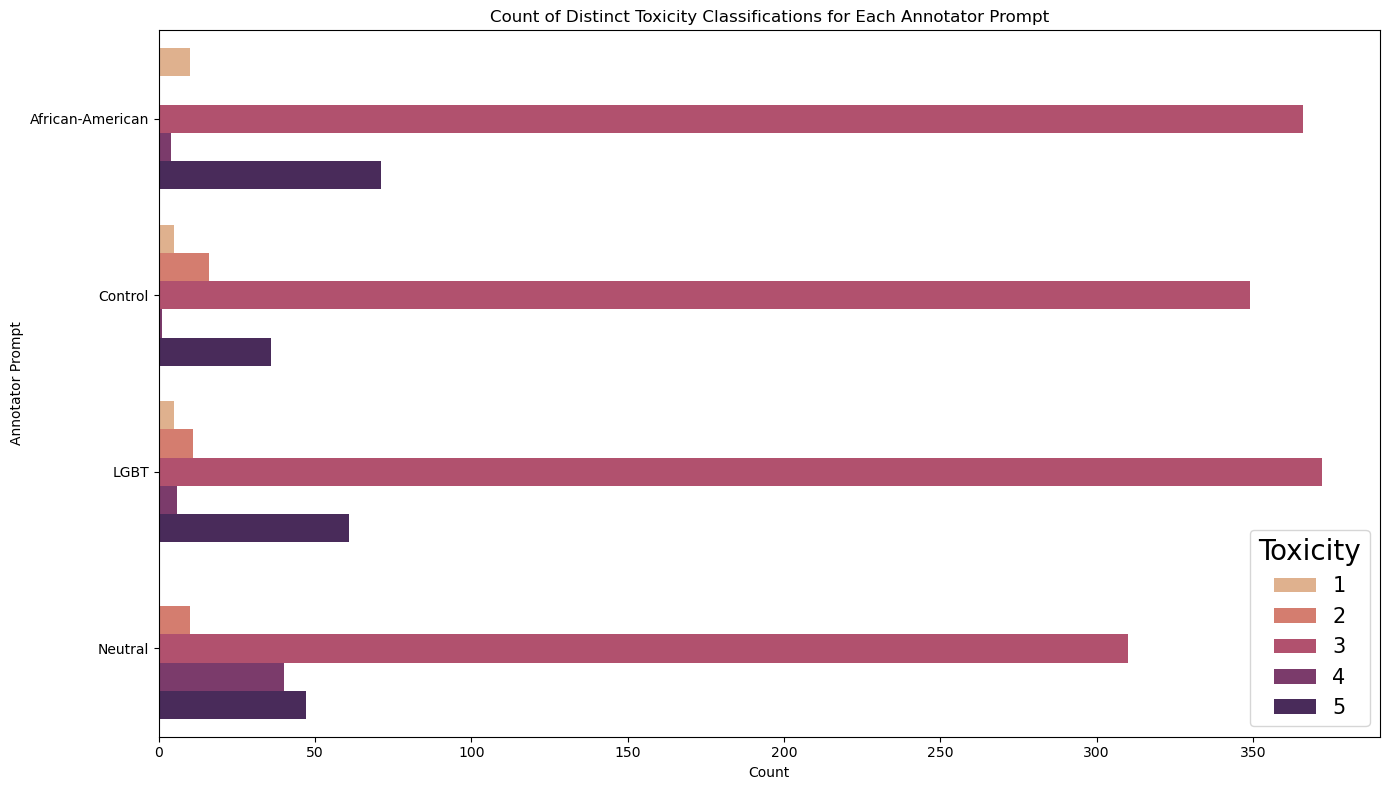

In [6]:
# Calculate the count of each toxicity classification per annotator_prompt
toxicity_counts = full_df.groupby(['annotator_prompt', 'toxicity']).size().reset_index(name='count')

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(
    data=toxicity_counts,
    y='annotator_prompt',
    x='count',
    hue='toxicity',
    palette='flare'
)

# Adding title and labels
plt.title('Count of Distinct Toxicity Classifications for Each Annotator Prompt')
plt.ylabel('Annotator Prompt')
plt.xlabel('Count')
plt.legend(title='Toxicity', fontsize='15', title_fontsize='20')

# Show plot
plt.tight_layout()
plt.show()

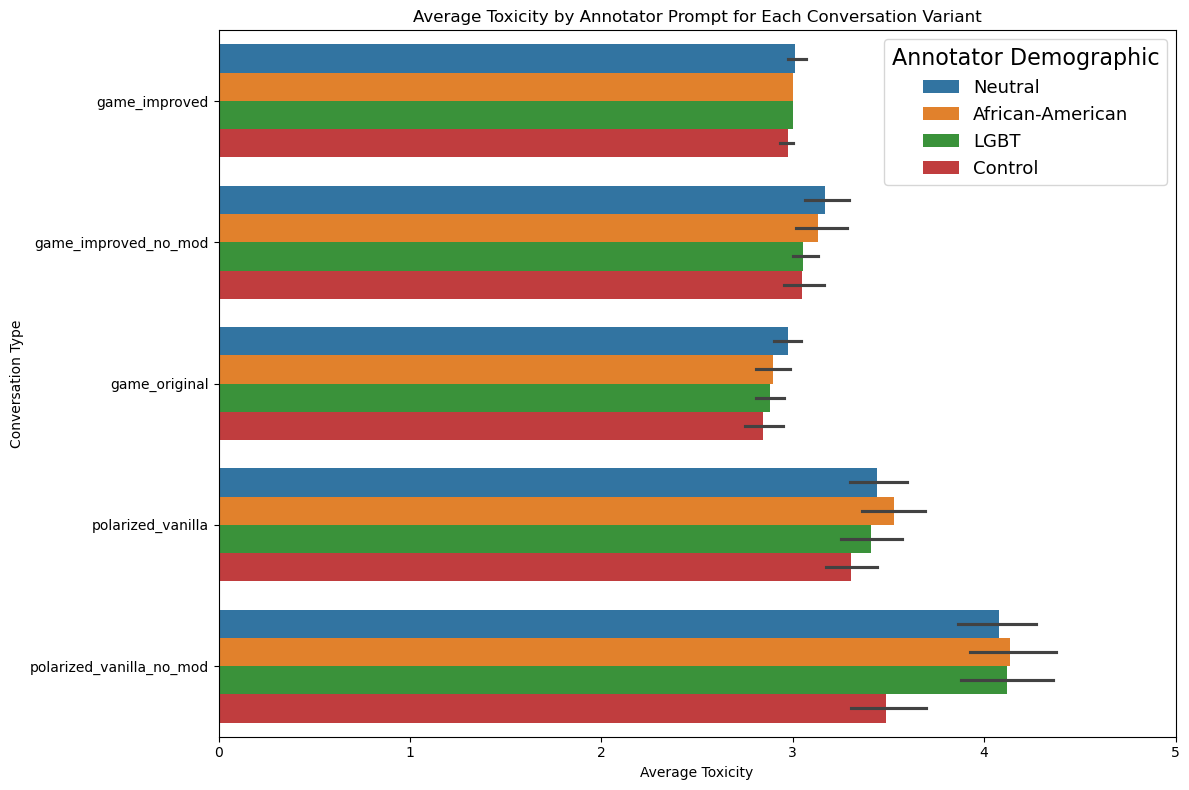

In [7]:
# Creating the plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=full_df,
    y='conv_variant',
    x='toxicity',
    hue='annotator_prompt',
    estimator=np.mean,
)

# Adding title and labels
plt.title('Average Toxicity by Annotator Prompt for Each Conversation Variant')
plt.ylabel('Conversation Type')
plt.xlabel('Average Toxicity')
plt.xlim(0, 5)
plt.legend(title='Annotator Demographic', fontsize='13', title_fontsize='16')

# Show plot
plt.tight_layout()
plt.show()